# Multiplayer vs Singleplayer játékok osztályozása

## Probléma leírása

A videójátékok egyik alapvető jellemzője, hogy egyedül (singleplayer) vagy más játékosokkal együtt (multiplayer) játszhatók. Ez a tulajdonság fontos szerepet játszik a játékosok döntéseiben, ezért érdemes megvizsgálni, hogy automatizált módon előrejelezhető-e.

Ebben a munkában egy **felügyelt, bináris osztályozási problémát** vizsgálok, amelynek célja annak meghatározása, hogy egy videójáték **multiplayer** vagy **singleplayer** jellegű-e.

## Célváltozó (Target)

A célváltozó egy bináris változó:

- `1` – a játék rendelkezik multiplayer (pl. online, co-op, PvP) funkcióval  
- `0` – a játék kizárólag singleplayer módban játszható

A címkét a játék kategóriái (categories) alapján határozom meg.

## Bemeneti jellemzők

A predikcióhoz az alábbi információkat használom fel:

- Szöveges leírások (`about_the_game`, `short_description`)
- Műfajok (genres)
- Címkék (tags)
- Egyéb alapvető metaadatok (pl. ár)

A szöveges adatokat természetesnyelv-feldolgozási módszerekkel, a strukturált adatokat bináris kódolással dolgozom fel.

## Alkalmazott módszerek

Az osztályozási feladat megoldására logisztikus regressziót és lineáris SVM modellt alkalmazok, a teljesítményt pedig többek között **F1-score** és **konfúziós mátrix** segítségével értékelem.


## Adatbetöltés

In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

DATA_DIR = Path(r"C:\Users\zalma\videogame-data-analysis\split")
OUTPUT_DIR = Path(r"C:\Users\zalma\videogame-data-analysis\notebooks\Classification\output")

# --- FŐ TÁBLA ---
game = pd.read_csv(DATA_DIR / "game.csv")

# -------------------------------
# Leírások
# -------------------------------
description = pd.read_csv(DATA_DIR / "description.csv")

# --- MŰFAJOK (genres) ---
game_genre = pd.read_csv(DATA_DIR / "game_genre.csv")
genres = pd.read_csv(DATA_DIR / "genres.csv")

# --- KATEGÓRIÁK (categories) ---
game_category = pd.read_csv(DATA_DIR / "game_category.csv")
categories = pd.read_csv(DATA_DIR / "categories.csv")

# --- CÍMKÉK (tags) ---
game_tag = pd.read_csv(DATA_DIR / "game_tag.csv")
tags = pd.read_csv(DATA_DIR / "tags.csv")

print("game shape:", game.shape)
print("description shape:", description.shape)
print("game_genre shape:", game_genre.shape, "| genres shape:", genres.shape)
print("game_category shape:", game_category.shape, "| categories shape:", categories.shape)
print("game_tag shape:", game_tag.shape, "| tags shape:", tags.shape)

print("\n--- game columns ---")
print(game.columns.tolist())

game.head()

game shape: (112855, 29)
description shape: (112855, 5)
game_genre shape: (112855, 2) | genres shape: (112855, 2)
game_category shape: (112855, 2) | categories shape: (112855, 2)
game_tag shape: (1116858, 2) | tags shape: (1116858, 3)

--- game columns ---
['appid', 'name', 'release_date', 'estimated_owners', 'required_age', 'price', 'dlc_count', 'num_recommendations', 'notes', 'website', 'metacritic_score', 'metacritic_url', 'num_achievements', 'user_score', 'score_rank', 'positive', 'negative', 'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'peak_ccu', 'discount', 'pct_pos_total', 'pct_pos_recent', 'num_reviews_total', 'num_reviews_recent', 'reviews', 'english']


,appid,name,release_date,estimated_owners,required_age,price,dlc_count,num_recommendations,notes,website,...,median_playtime_forever,median_playtime_2weeks,peak_ccu,discount,pct_pos_total,pct_pos_recent,num_reviews_total,num_reviews_recent,reviews,english
0,10,Counter-Strike,2000-11-01,10000000 - 20000000,0.0,9.99,0.0,149445.0,Includes intense violence and blood.,NaN,...,0.0,0.0,11703.0,NaN,96.0,95.0,149589.0,908.0,NaN,1.0
1,20,Team Fortress Classic,1999-04-01,5000000 - 10000000,0.0,4.99,0.0,6454.0,Includes intense violence and blood.,NaN,...,15.0,0.0,46.0,0.0,86.0,76.0,6482.0,56.0,NaN,1.0
2,30,Day of Defeat,2003-05-01,5000000 - 10000000,0.0,4.99,0.0,4032.0,NaN,http://www.dayofdefeat.com/,...,0.0,0.0,101.0,NaN,87.0,97.0,4038.0,36.0,NaN,1.0
3,40,Deathmatch Classic,2001-06-01,5000000 - 10000000,0.0,4.99,0.0,2113.0,NaN,NaN,...,7.0,0.0,4.0,NaN,81.0,95.0,2120.0,21.0,NaN,1.0
4,50,Half-Life: Opposing Force,1999-11-01,2000000 - 5000000,0.0,4.99,0.0,18908.0,NaN,NaN,...,161.0,36.0,87.0,NaN,95.0,95.0,18994.0,269.0,NaN,1.0


## Célváltozó létrehozása

Ebben a részben a játékok kategóriái alapján bináris célváltozót hozok létre, amely azt jelöli, hogy egy játék rendelkezik-e multiplayer funkcióval. A kategóriák neveit felhasználva megkülönböztetem a multiplayer és a kizárólag singleplayer játékokat.

In [2]:
appid_col = "appid"

cat_id_col = "catid"
cat_name_col = "name"

gc = game_category.merge(
    categories[[cat_id_col, cat_name_col]],
    on=cat_id_col,
    how="left"
)

def split_categories(s):
    if pd.isna(s):
        return []
    parts = re.split(r"[;,]", str(s))
    return [p.strip().lower() for p in parts if p.strip()]

gc["category_list"] = gc[cat_name_col].apply(split_categories)

multiplayer_keywords = [
    "multi-player", "multiplayer",
    "online pvp", "pvp",
    "local multiplayer",
    "co-op", "coop", "online co-op", "local co-op",
    "mmo", "massively multiplayer"
]

singleplayer_keywords = [
    "single-player", "singleplayer"
]

gc["is_multiplayer"] = gc["category_list"].apply(
    lambda lst: any(
        any(k in cat for k in multiplayer_keywords)
        for cat in lst
    )
).astype(int)

gc["is_singleplayer"] = gc["category_list"].apply(
    lambda lst: any(
        any(k in cat for k in singleplayer_keywords)
        for cat in lst
    )
).astype(int)

agg = (
    gc.groupby(appid_col)[["is_multiplayer", "is_singleplayer"]]
    .max()
    .reset_index()
)

agg["y_multiplayer"] = (agg["is_multiplayer"] == 1).astype(int)

labeled = agg[
    (agg["is_multiplayer"] == 1) | (agg["is_singleplayer"] == 1)
].copy()

df = game.merge(
    labeled[[appid_col, "y_multiplayer"]],
    on=appid_col,
    how="inner"
)

print("Labeled dataset shape:", df.shape)

print("\nTarget eloszlás (0 = singleplayer, 1 = multiplayer):")
print(df["y_multiplayer"].value_counts())

print("\nTarget eloszlás (%):")
print((df["y_multiplayer"].value_counts(normalize=True) * 100).round(2))

Labeled dataset shape: (104701, 30)

Target eloszlás (0 = singleplayer, 1 = multiplayer):
y_multiplayer
0    84825
1    19876
Name: count, dtype: int64

Target eloszlás (%):
y_multiplayer
0    81.02
1    18.98
Name: proportion, dtype: float64


## Szöveges leírások csatolása

Ebben a lépésben a játékokhoz tartozó szöveges leírásokat a `description` táblából az `appid` azonosító alapján csatolom a fő adathalmazhoz. A részletes és rövid leírásokat egyetlen szöveges mezőbe vonom össze, amelyet a későbbi természetesnyelv-feldolgozási lépések során használok fel.


In [3]:
desc_cols = [
    "appid",
    "about_the_game",
    "short_description"
]

desc = description[desc_cols].copy()

desc["about_the_game"] = desc["about_the_game"].fillna("")
desc["short_description"] = desc["short_description"].fillna("")

desc["text"] = (
    desc["about_the_game"] + " " + desc["short_description"]
).str.strip()

df = df.merge(
    desc[["appid", "text"]],
    on="appid",
    how="left"
)

print("After description join:", df.shape)
print("\nMissing text values:", df["text"].isna().sum())

df[["appid", "text"]].head()

After description join: (104701, 31)

Missing text values: 0


,appid,text
0,10,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...
4,50,Return to the Black Mesa Research Facility as ...


## Szöveg előtisztítás

Ebben a lépésben az összevont szöveges leírásokat előtisztítom a természetesnyelv-feldolgozás előtt. Az előfeldolgozás során eltávolítom a HTML tageket, URL-eket és speciális karaktereket, valamint egységesítem a szöveget a későbbi vektorizáláshoz.


In [4]:
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    
    s = s.lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    
    return s

df["text"] = df["text"].fillna("")

df["text_clean"] = df["text"].apply(clean_text)

print("Üres text_clean sorok száma:", (df["text_clean"].str.len() == 0).sum())
df[["text", "text_clean"]].head(3)

Üres text_clean sorok száma: 207


,text,text_clean
0,Play the world's number 1 online action game. ...,play the world s number 1 online action game e...
1,One of the most popular online action games of...,one of the most popular online action games of...
2,Enlist in an intense brand of Axis vs. Allied ...,enlist in an intense brand of axis vs allied t...


## TF-IDF vektorizálás

A szöveges leírásokat TF-IDF (Term Frequency – Inverse Document Frequency) reprezentációval alakítottam numerikus formára.  
A módszer lényege, hogy az adott dokumentumban gyakran előforduló, de a teljes szövegállományban ritkább szavak nagyobb súlyt kapnak.

A vektorizálás során a következő paramétereket használtam:
- unigram és bigram kifejezések
- minimum dokumentumgyakoriság (`min_df`)
- maximális szókészletméret (`max_features`)

A következő lépésben konkrétan megvizsgálom, hogy ezek milyen dimenziószámú vektort eredményeznek.


In [5]:
tfidf_demo = TfidfVectorizer(
    max_features=50_000,
    ngram_range=(1, 2),
    min_df=5
)

X_tfidf = tfidf_demo.fit_transform(df["text_clean"])

print("TF-IDF mátrix alakja:", X_tfidf.shape)
print("Szókészlet mérete:", len(tfidf_demo.vocabulary_))


TF-IDF mátrix alakja: (104701, 50000)
Szókészlet mérete: 50000


A TF-IDF vektorizálás eredményeként egy `(104701 × 50000)` dimenziójú, ritka mátrix jött létre, ahol a sorok a játékok leírásait, az oszlopok pedig a szókészlet elemeit (unigramok és bigramok) reprezentálják.

A szókészlet mérete elérte az előre beállított `max_features = 50000` korlátot, ami azt jelzi, hogy a szövegállomány nyelvi változatossága jelentős.  
Ez a nagy dimenziószám indokolja a lineáris osztályozók (Logistic Regression, LinearSVC) alkalmazását, amelyek jól kezelik a nagy dimenziós, sparse reprezentációkat.


## Baseline modell (csak szöveg)

Ebben a részben egy egyszerű baseline modellt tanítok a tisztított szöveges leírások alapján.  
A szöveget TF-IDF vektorizálom, majd logisztikus regresszióval bináris osztályozást végzek (multiplayer vs singleplayer).


Train size: 83760 | Test size: 20941
Train target %:
 y_multiplayer
0    81.02
1    18.98
Name: proportion, dtype: float64
Test target %:
 y_multiplayer
0    81.02
1    18.98
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

           0     0.9649    0.9523    0.9586     16966
           1     0.8072    0.8523    0.8292      3975

    accuracy                         0.9333     20941
   macro avg     0.8861    0.9023    0.8939     20941
weighted avg     0.9350    0.9333    0.9340     20941



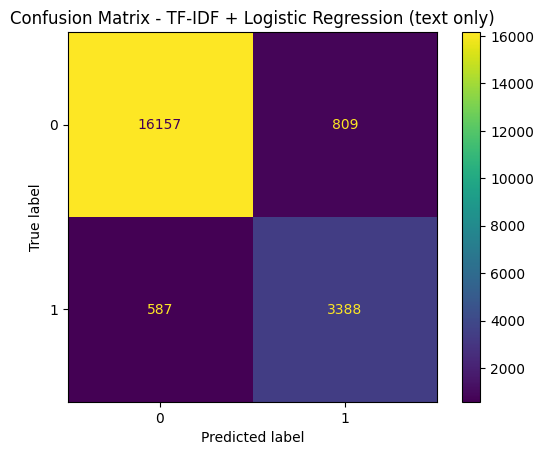

In [6]:
X = df["text_clean"]
y = df["y_multiplayer"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0], "| Test size:", X_test.shape[0])
print("Train target %:\n", (y_train.value_counts(normalize=True)*100).round(2))
print("Test target %:\n", (y_test.value_counts(normalize=True)*100).round(2))

text_clf = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        min_df=5
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - TF-IDF + Logistic Regression (text only)")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_TF.png")
plt.show()

## Alternatív baseline: Lineáris SVM (csak szöveg)

Ebben a részben a korábbi TF-IDF szövegreprezentációt megtartva egy lineáris SVM modellt tanítok.  
A lineáris SVM gyakran különösen jól teljesít nagy dimenziós, ritka (TF-IDF) bemeneteken.


Classification report (TF-IDF + LinearSVC):
              precision    recall  f1-score   support

           0     0.9608    0.9609    0.9608     16966
           1     0.8329    0.8327    0.8328      3975

    accuracy                         0.9365     20941
   macro avg     0.8969    0.8968    0.8968     20941
weighted avg     0.9365    0.9365    0.9365     20941



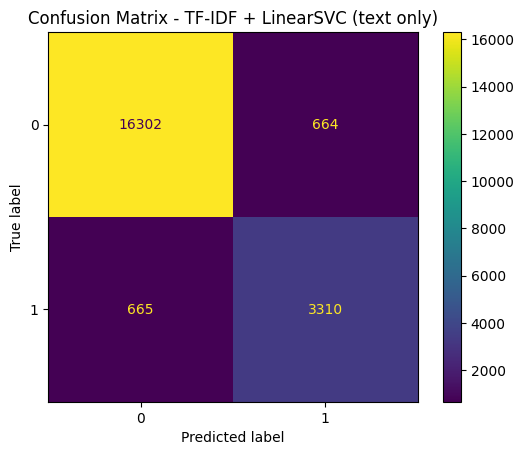

In [7]:
svm_clf = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        min_df=5
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("Classification report (TF-IDF + LinearSVC):")
print(classification_report(y_test, y_pred_svm, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title("Confusion Matrix - TF-IDF + LinearSVC (text only)")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_tfidf_linearsvc_text_only.png")
plt.show()

## Strukturált jellemzők hozzáadása

Ebben a részben a szöveges leírások mellett strukturált metaadatokat is felhasználok a modell tanításához.  
A játékokhoz tartozó címkéket (tags) és műfajokat (genres) bináris (multi-hot) formában kódolom, majd ezeket a szöveges jellemzőkkel együtt használom fel az osztályozás során.


In [8]:
def split_multi(s):
    if pd.isna(s):
        return []
    parts = re.split(r"[;,]", str(s))
    return [p.strip().lower() for p in parts if p.strip()]

gt = game_tag.merge(
    tags[["tagid", "tag_name"]],
    on="tagid",
    how="left"
)

gt["tag_norm"] = gt["tag_name"].astype(str).str.lower().str.strip()
gt = gt.dropna(subset=["tag_norm"]).drop_duplicates(subset=["appid", "tag_norm"])

TOP_N_TAGS = 300
top_tags = gt["tag_norm"].value_counts().head(TOP_N_TAGS).index.tolist()
gt = gt[gt["tag_norm"].isin(top_tags)]

tags_per_game = gt.groupby("appid")["tag_norm"].apply(list).reset_index()

mlb_tags = MultiLabelBinarizer()
tags_encoded = mlb_tags.fit_transform(tags_per_game["tag_norm"])

tags_df = pd.DataFrame(
    tags_encoded,
    columns=[f"tag_{t}" for t in mlb_tags.classes_]
)
tags_df["appid"] = tags_per_game["appid"]

gg = game_genre.merge(
    genres[["genreid", "genre_name"]],
    on="genreid",
    how="left"
)

gg["genre_list"] = gg["genre_name"].apply(split_multi)

gg_exploded = (
    gg[["appid", "genre_list"]]
    .explode("genre_list")
    .dropna(subset=["genre_list"])
    .rename(columns={"genre_list": "genre_norm"})
    .drop_duplicates(subset=["appid", "genre_norm"])
)

MIN_GAMES_PER_GENRE = 50
vc = gg_exploded["genre_norm"].value_counts()
valid_genres = vc[vc >= MIN_GAMES_PER_GENRE].index
gg_exploded = gg_exploded[gg_exploded["genre_norm"].isin(valid_genres)]

genres_per_game = gg_exploded.groupby("appid")["genre_norm"].apply(list).reset_index()

mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(genres_per_game["genre_norm"])

genres_df = pd.DataFrame(
    genres_encoded,
    columns=[f"genre_{g}" for g in mlb_genres.classes_]
)
genres_df["appid"] = genres_per_game["appid"]

df_feat = (
    df.merge(tags_df, on="appid", how="left")
      .merge(genres_df, on="appid", how="left")
)

new_feature_cols = [c for c in df_feat.columns if c.startswith("tag_") or c.startswith("genre_")]
df_feat[new_feature_cols] = df_feat[new_feature_cols].fillna(0).astype(int)

df_feat.head()


,appid,name,release_date,estimated_owners,required_age,price,dlc_count,num_recommendations,notes,website,...,genre_rpg,genre_sexual content,genre_simulation,genre_software training,genre_sports,genre_strategy,genre_utilities,genre_video production,genre_violent,genre_web publishing
0,10,Counter-Strike,2000-11-01,10000000 - 20000000,0.0,9.99,0.0,149445.0,Includes intense violence and blood.,NaN,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,5000000 - 10000000,0.0,4.99,0.0,6454.0,Includes intense violence and blood.,NaN,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,5000000 - 10000000,0.0,4.99,0.0,4032.0,NaN,http://www.dayofdefeat.com/,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,5000000 - 10000000,0.0,4.99,0.0,2113.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,2000000 - 5000000,0.0,4.99,0.0,18908.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


## Kombinált modell (szöveg + tagek + műfajok)

Ebben a részben a TF-IDF szöveg-jellemzőket és a bináris strukturált jellemzőket (tagek, műfajok) együttesen használom fel az osztályozáshoz.


Classification report (combined | LogisticRegression):
              precision    recall  f1-score   support

           0     0.9748    0.9696    0.9722     16966
           1     0.8733    0.8928    0.8829      3975

    accuracy                         0.9551     20941
   macro avg     0.9240    0.9312    0.9276     20941
weighted avg     0.9555    0.9551    0.9553     20941



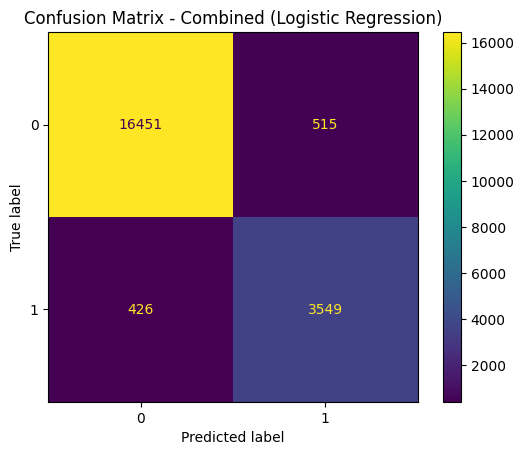

In [9]:
y = df_feat["y_multiplayer"].astype(int)
text_col = "text_clean"
structured_cols = [c for c in df_feat.columns if c.startswith("tag_") or c.startswith("genre_")]
X = df_feat[[text_col] + structured_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=50_000, ngram_range=(1, 2), min_df=5), text_col),
        ("struct", "passthrough", structured_cols),
    ],
    sparse_threshold=0.3
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification report (combined | LogisticRegression):")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Combined (Logistic Regression)")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_tfidf_logreg_combined.png")
plt.show()

## Kombinált modell (LinearSVC)

Ebben a részben a szöveges leírásokat és a strukturált jellemzőket együttesen felhasználva egy lineáris SVM modellt tanítok.  
A lineáris SVM különösen jól teljesít nagy dimenziós, ritka bemeneteken, mint amilyenek a TF-IDF reprezentációk.


Classification report (Combined | LinearSVC):
              precision    recall  f1-score   support

           0     0.9720    0.9768    0.9744     16966
           1     0.8987    0.8797    0.8891      3975

    accuracy                         0.9584     20941
   macro avg     0.9354    0.9283    0.9318     20941
weighted avg     0.9581    0.9584    0.9582     20941



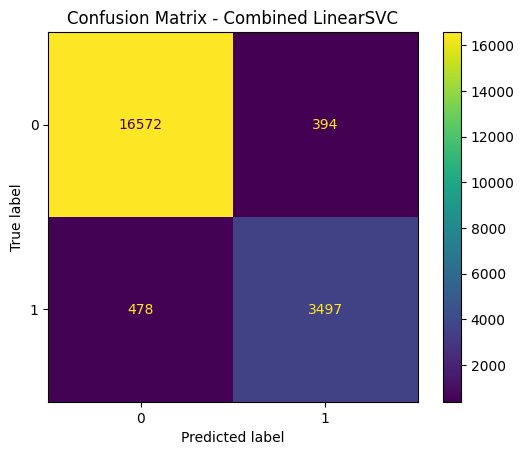

In [10]:
y = df_feat["y_multiplayer"].astype(int)

text_col = "text_clean"
structured_cols = [c for c in df_feat.columns if c.startswith("tag_") or c.startswith("genre_")]

X = df_feat[[text_col] + structured_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=50_000,
            ngram_range=(1, 2),
            min_df=5
        ), text_col),
        ("struct", "passthrough", structured_cols)
    ],
    sparse_threshold=0.3
)

svm_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

print("Classification report (Combined | LinearSVC):")
print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Combined LinearSVC")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_tfidf_linearsvc_combined.png")
plt.show()

## Modell magyarázhatósága – lényeges szavak a leírásokban (description)

A következőkben a legjobb teljesítményt nyújtó lineáris SVM modell tanult súlyai alapján megvizsgálom,  
hogy a játékok szöveges leírásaiból (description mező) mely szavak, illetve mely strukturált jellemzők  
járultak hozzá leginkább a multiplayer és a singleplayer besoroláshoz.


In [11]:
feature_names = svm_clf.named_steps["prep"].get_feature_names_out()

coef = svm_clf.named_steps["clf"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "weight": coef
})

top_multiplayer = coef_df.sort_values("weight", ascending=False).head(20)
top_singleplayer = coef_df.sort_values("weight").head(20)

print("Top multiplayer irányba toló jellemzők:")
display(top_multiplayer)

print("Top singleplayer irányba toló jellemzők:")
display(top_singleplayer)

text_features = coef_df[coef_df["feature"].str.startswith("text__")]
tag_features = coef_df[coef_df["feature"].str.startswith("struct__tag_")]
genre_features = coef_df[coef_df["feature"].str.startswith("struct__genre_")]

text_features_clean = text_features.copy()

print("Description:")

display(text_features_clean.sort_values("weight", ascending=False).head(15))
display(text_features_clean.sort_values("weight").head(15))

Top multiplayer irányba toló jellemzők:


,feature,weight
26749,text__multiplayer,13.136651
9369,text__co op,6.455240
29465,text__online,4.757305
29563,text__op,4.727887
10380,text__cooperative,4.601634
9367,text__co,4.301595
32896,text__pvp,4.296627
44841,text__two player,4.259893
43690,text__to players,4.231682
47886,text__with friend,4.216258


Top singleplayer irányba toló jellemzők:


,feature,weight
41125,text__the player,-2.952984
36257,text__single player,-2.073761
22353,text__is single,-2.067870
40748,text__the local,-1.882919
9373,text__coaches,-1.800776
15475,text__features,-1.761795
34398,text__roadmap,-1.753995
38196,text__successful,-1.671076
37317,text__squash,-1.585833
41005,text__the online,-1.584867


Description:


,feature,weight
26749,text__multiplayer,13.136651
9369,text__co op,6.455240
29465,text__online,4.757305
29563,text__op,4.727887
10380,text__cooperative,4.601634
9367,text__co,4.301595
32896,text__pvp,4.296627
44841,text__two player,4.259893
43690,text__to players,4.231682
47886,text__with friend,4.216258


,feature,weight
41125,text__the player,-2.952984
36257,text__single player,-2.073761
22353,text__is single,-2.067870
40748,text__the local,-1.882919
9373,text__coaches,-1.800776
15475,text__features,-1.761795
34398,text__roadmap,-1.753995
38196,text__successful,-1.671076
37317,text__squash,-1.585833
41005,text__the online,-1.584867


In [12]:
text_features = coef_df[coef_df["feature"].str.startswith("text__")]
tag_features = coef_df[coef_df["feature"].str.startswith("struct__tag_")]
genre_features = coef_df[coef_df["feature"].str.startswith("struct__genre_")]

print("Top multiplayer SZAVAK:")
display(text_features.sort_values("weight", ascending=False).head(15))

print("Top multiplayer TAG-ek:")
display(tag_features.sort_values("weight", ascending=False).head(15))

print("Top multiplayer GENRE-ek:")
display(genre_features.sort_values("weight", ascending=False).head(15))


Top multiplayer SZAVAK:


,feature,weight
26749,text__multiplayer,13.136651
9369,text__co op,6.455240
29465,text__online,4.757305
29563,text__op,4.727887
10380,text__cooperative,4.601634
9367,text__co,4.301595
32896,text__pvp,4.296627
44841,text__two player,4.259893
43690,text__to players,4.231682
47886,text__with friend,4.216258


Top multiplayer TAG-ek:


,feature,weight
50148,struct__tag_local co-op,1.203608
50211,struct__tag_pvp,0.974280
50172,struct__tag_multiplayer,0.884638
50250,struct__tag_split screen,0.846262
50060,struct__tag_co-op campaign,0.831325
50186,struct__tag_online co-op,0.629526
50149,struct__tag_local multiplayer,0.618040
50010,struct__tag_4 player local,0.517841
50059,struct__tag_co-op,0.493867
50168,struct__tag_mmorpg,0.298122


Top multiplayer GENRE-ek:


,feature,weight
50312,struct__genre_massively multiplayer,1.259602
50303,struct__genre_audio production,0.304322
50309,struct__genre_game development,0.279999
50325,struct__genre_web publishing,0.274400
50308,struct__genre_free to play,0.211405
50321,struct__genre_strategy,0.164356
50315,struct__genre_racing,0.136005
50300,struct__genre_action,0.113794
50302,struct__genre_animation & modeling,0.110571
50320,struct__genre_sports,0.108771


## A modell döntéseinek értelmezése

A lineáris SVM modell tanult súlyainak vizsgálata alapján jól látható, hogy a becslések mögött értelmezhető, szemantikailag releváns jellemzők állnak.

A játékok szöveges leírásaiból (description mező) származó jellemzők közül a multiplayer irányba legnagyobb súllyal olyan szavak járulnak hozzá, amelyek explicit módon többjátékos mechanikákra utalnak (pl. *multiplayer*, *online*, *co-op*, *pvp*, *split screen*). Ezek a mintázatok következetesen megjelennek a leírásokban, és összhangban vannak a játékok tényleges játékmenetével.

Ezzel szemben a singleplayer besorolást elsősorban narratív, tanulási vagy egyéni játékélményhez kötődő kifejezések támogatják (pl. *single player*, *prologue*, *tutorial*, *novel*, *idle*).

Az eredmények azt mutatják, hogy a modell nem véletlenszerű korrelációk alapján dönt, hanem a játékok leírásaiban megjelenő, emberileg is jól értelmezhető kulcsszavakra támaszkodik, ami a megoldás magyarázhatóságát és megbízhatóságát is alátámasztja.


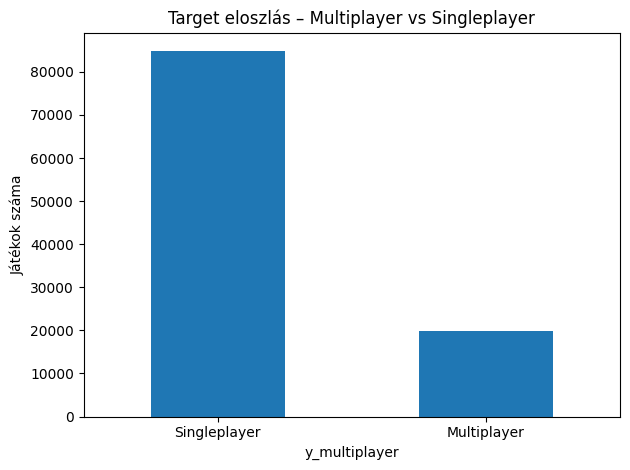

In [13]:
df_feat["y_multiplayer"].value_counts().plot(
    kind="bar",
    title="Target eloszlás – Multiplayer vs Singleplayer"
)
plt.xticks([0, 1], ["Singleplayer", "Multiplayer"], rotation=0)
plt.ylabel("Játékok száma")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_target_distribution_multiplayer.png")
plt.show()


Az adathalmazban a multiplayer és singleplayer játékok eloszlása nem kiegyensúlyozott.  
A singleplayer játékok jelentős többségben vannak, míg a multiplayer címek aránya körülbelül 20%.  
Ez az osztályarány-indokolja az osztályozási modellekben a kiegyensúlyozott súlyozás alkalmazását.


C:\Users\zalma\AppData\Local\Temp\ipykernel_5964\555952769.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat["desc_len"] = df_feat["text_clean"].str.split().str.len()


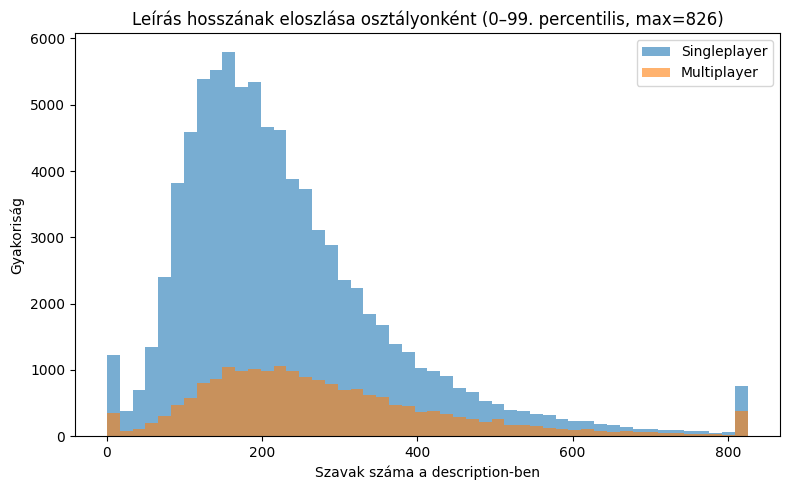

In [14]:
df_feat["desc_len"] = df_feat["text_clean"].str.split().str.len()

x_max = int(np.percentile(df_feat["desc_len"], 99))

plt.figure(figsize=(8, 5))

plt.hist(
    df_feat[df_feat["y_multiplayer"] == 0]["desc_len"].clip(upper=x_max),
    bins=50,
    alpha=0.6,
    label="Singleplayer"
)
plt.hist(
    df_feat[df_feat["y_multiplayer"] == 1]["desc_len"].clip(upper=x_max),
    bins=50,
    alpha=0.6,
    label="Multiplayer"
)

plt.title(f"Leírás hosszának eloszlása osztályonként (0–99. percentilis, max={x_max})")
plt.xlabel("Szavak száma a description-ben")
plt.ylabel("Gyakoriság")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_description_length_distribution_by_class_p99_normalized.png")
plt.show()



A játékok szöveges leírásának hossza jelentős szórást mutat.  
Az eloszlás jobbra elnyúló, ezért az ábrán a szélsőséges értékek hatását percentilis alapú vágással csökkentettük.  
Megfigyelhető, hogy a multiplayer játékok leírásai átlagosan hosszabbak, ami összefügghet a komplexebb játékmechanikák bemutatásával.
